# set up

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ensembles"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# import dataset

In [2]:
import pandas as pd
data = pd.read_excel(r'C:\Users\ASUS\Desktop\machine learning\MLfinalReport\AHIdata.xlsx')

In [3]:
df = pd.DataFrame(data, columns=['rescored AHI'])
print(type(df))#datatype is pd.dataframe not numpy array
df_2D = df.to_numpy()#convert into numpy array

<class 'pandas.core.frame.DataFrame'>


In [4]:
y_stack = df_2D.flatten()#flatten into 1d array

In [5]:
for count in range (0, 119):
    if y_stack[count]>=30:#AHI>=30, class:3
        y_stack[count]=3
    elif y_stack[count]>=15:#30>AHI>=15, class:2
        y_stack[count]=2
    elif y_stack[count]>=5:#15>AHI>=5, class: 1
        y_stack[count]=1
    else:
        y_stack[count]=0#5>AHI, class:0

# extract inputs form excel

In [6]:
#BMI
x1 = pd.DataFrame(data, columns=['BMI'])
x1_2D = x1.to_numpy()#convert into numpy array
x_bmi = x1_2D.flatten()#flatten into 1d array
#Age
x2 = pd.DataFrame(data, columns=['Age'])
x2_2D = x2.to_numpy()#convert into numpy array
x_age = x2_2D.flatten()#flatten into 1d array
#neck
x3 = pd.DataFrame(data, columns=['neck'])
x3_2D = x3.to_numpy()#convert into numpy array
x_neck = x3_2D.flatten()#flatten into 1d array
#desaturatino index
x4 = pd.DataFrame(data, columns=['desaturation index'])
x4_2D = x4.to_numpy()#convert into numpy array
x_dsi = x4_2D.flatten()#flatten into 1d array
#CVHR-OR_CEI
x5 = pd.DataFrame(data, columns=['Aligned CVHR-OR-CEI'])
x5_2D = x5.to_numpy()#convert into numpy array
x_cvhrorcei = x5_2D.flatten()#flatten into 1d array
#CVHRI
x6 = pd.DataFrame(data, columns=['CVHRI'])
x6_2D = x6.to_numpy()#convert into numpy array
x_cvhri = x6_2D.flatten()#flatten into 1d array
#CEI
x7 = pd.DataFrame(data, columns=['CEI'])
x7_2D = x7.to_numpy()#convert into numpy array
x_cei = x7_2D.flatten()#flatten into 1d array

## decide your inputs

In [7]:
X_stack = np.stack((x_cvhri, x_cei), axis=-1)

## test train validation split

In [8]:
from sklearn.model_selection import train_test_split 
X_trainval, X_test, y_trainval, y_test = train_test_split(X_stack, y_stack, test_size=0.15, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.4, shuffle=False)

## decide hyperparameter 

In [9]:
from sklearn.model_selection import GridSearchCV
param_dist = {
    'n_estimators':range(500, 1500, 100),
    'max_depth':range(1, 20, 1),
    }

In [10]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(random_state=42)
grid = GridSearchCV(rnd_clf, param_dist, cv=3, scoring='accuracy', n_jobs=-1)
grid.fit(X_val, y_val)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': range(1, 20),
                         'n_estimators': range(500, 1500, 100)},
             scoring='accuracy')

In [11]:
grid.best_params_

{'max_depth': 1, 'n_estimators': 500}

In [12]:
rnd_clf = RandomForestClassifier(n_estimators=grid.best_params_.get('n_estimators'), 
                                 max_depth=grid.best_params_.get('max_depth'), 
                                 random_state=42)
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)

### code from: https://medium.com/analytics-vidhya/evaluating-a-random-forest-model-9d165595ad56

In [13]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
accuracy_score(y_test, y_pred_rf)

0.8333333333333334

In [14]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
confusion_matrix(y_test, y_pred_rf)

array([[ 4,  3],
       [ 0, 11]], dtype=int64)

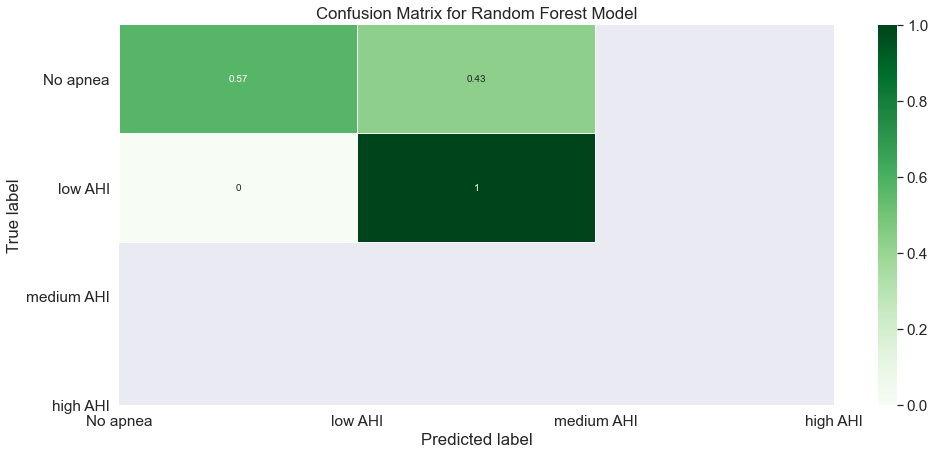

In [15]:
import seaborn as sns
# Get and reshape confusion matrix data
matrix = confusion_matrix(y_test, y_pred_rf)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['No apnea', 'low AHI', 'medium AHI', 'high AHI']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=0)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

In [16]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

         0.0       1.00      0.57      0.73         7
         1.0       0.79      1.00      0.88        11

    accuracy                           0.83        18
   macro avg       0.89      0.79      0.80        18
weighted avg       0.87      0.83      0.82        18



## AUC

In [17]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
y_score = rnd_clf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_score, pos_label=1)
area=roc_auc_score(y_test, y_score)
# metrics.auc(fpr, tpr)

<function matplotlib.pyplot.show(close=None, block=None)>

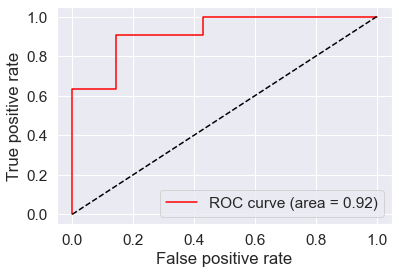

In [18]:
plt.figure()
plt.plot(fpr, tpr, color='red', label='ROC curve (area = %0.2f)' %area)
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='lower right')
plt.show